<a href="https://colab.research.google.com/github/PhuongAnh2212/-APT_AnswerSheetChecker/blob/main/APT_Assignment3_210191.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
pip install torch torchvision

In [ ]:
import skimage.io
import skimage
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import math
import cv2 as cv # only used with opencv

In [ ]:
def show_opencv_image_with_matplotlib(image_mat, dpi=150):
    nchannels = len(image_mat.shape)
    if(nchannels == 2):
        plt.figure(dpi=dpi) #resize window show
        plt.imshow(image_mat, cmap = 'gray')
        plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
        plt.show()
    else:
        b_,g_,r_ = cv.split(image_mat)
        image_mat_rgb = cv.merge([r_,g_,b_])
        plt.figure(dpi=dpi) #resize window show
        plt.imshow(image_mat_rgb)
        plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
        plt.show()

### Load the mage “input-blobDetection.jpg

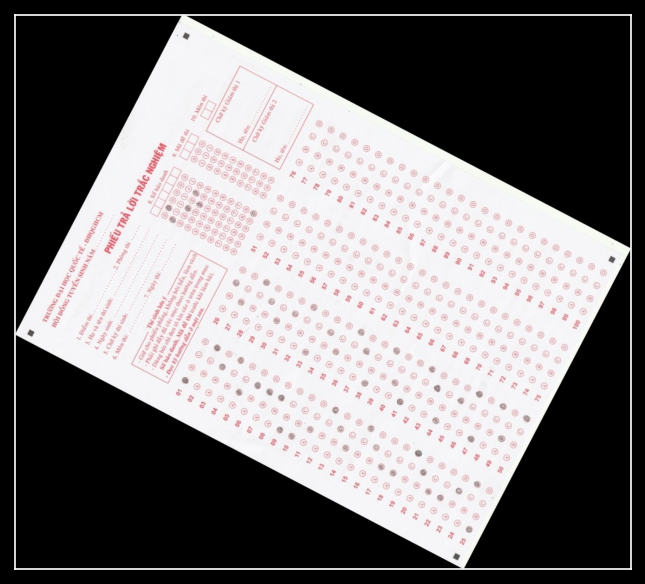

In [ ]:
image = cv.imread('/content/Blob Detection Assignment.jpg')
show_opencv_image_with_matplotlib(image)

### Define necessary kernel in 'Numpy'

In [ ]:
# Kernel to detect 'horizontal edges' of images
kernel_h = [ [1,2,1], [0,0,0], [-1,-2,-1] ]
# Kernel to detect 'vertical edges' of images
kernel_v = [ [1,0,1], [2,0,-2], [-1,0,-1] ]
# Kernel to 'take sum of all pixels' in the image
kernel_sum = [ [1, 1, 1], [1, 1, 1], [1, 1, 1] ]
# Kernel to 'sharpen image'
kernel_sh = [ [ 0, -1.0, 0], [ -1.0, 5, -1.0], [0, -1.0, 0] ] #sharpen kernel

# Verify kernel len
if len(kernel_h) == 0 or len(kernel_v) == 0:
    print('Please specify the kernel!')

In [ ]:
print("Shape of result_b:", result_b.shape)

Shape of result_b: (920, 1022)


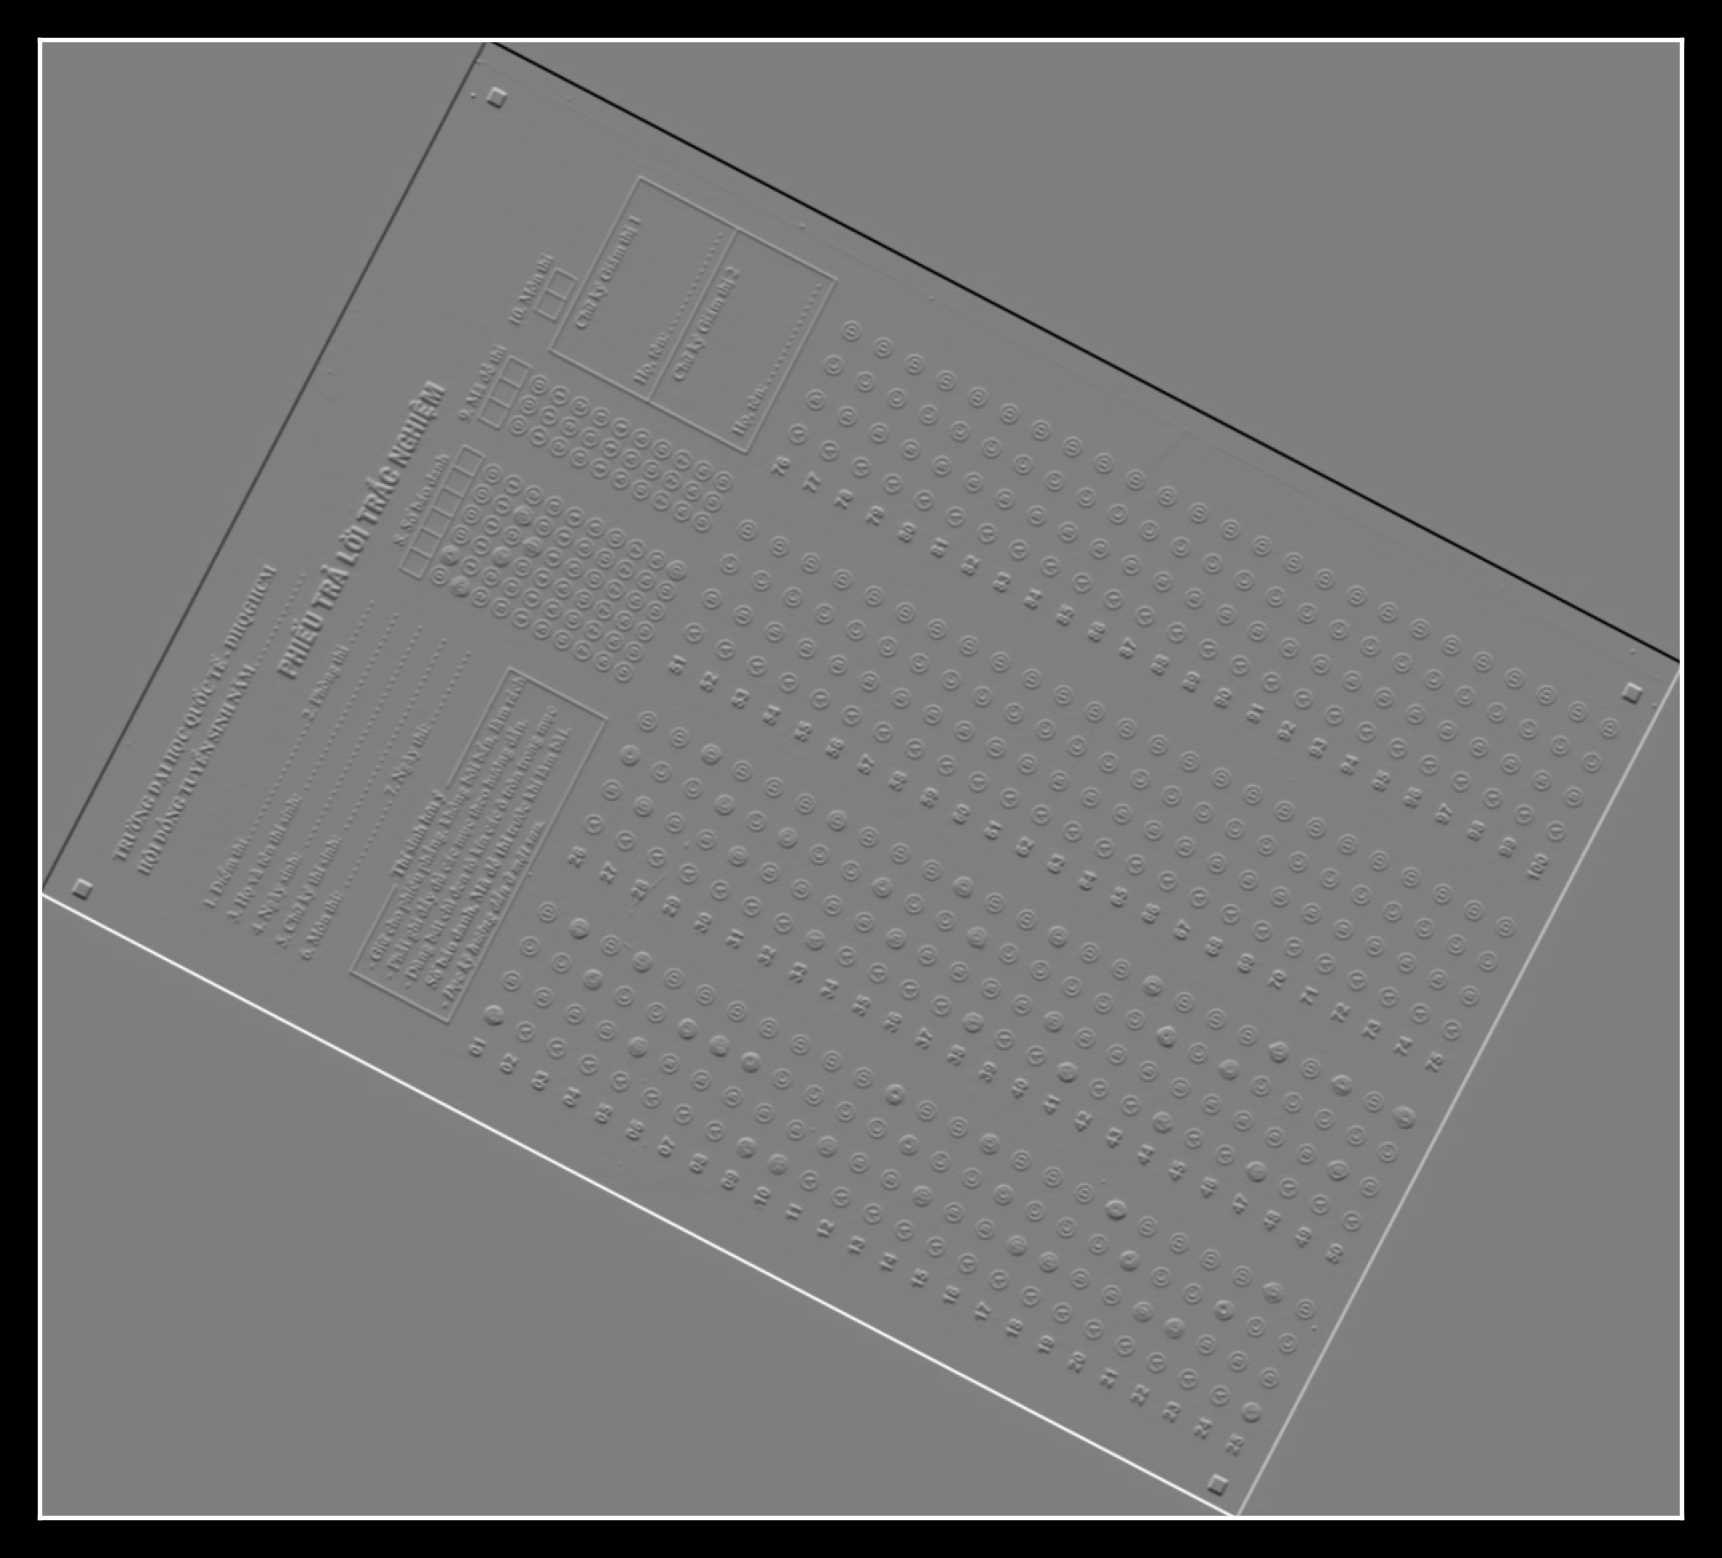

In [ ]:
conv_sh = torch.tensor(kernel_h, dtype=torch.float32)

# Extract image into 3 separate channels
b, g, r = image[:, :, 0], image[:, :, 1], image[:, :, 2]

# Define the function to perform convolution on a single channel
def perform_convolution(channel):
    input_tensor = torch.tensor(channel, dtype=torch.float32)
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    weight = conv_sh.unsqueeze(0).unsqueeze(0)

    # Perform convolution
    output_h = torch.nn.functional.conv2d(input=input_tensor, weight=weight, stride=1, padding=1)
    return output_h.squeeze().detach().numpy()  # Remove batch and channel dimensions, convert to NumPy

result_b = perform_convolution(b)
result_g = perform_convolution(g)
result_r = perform_convolution(r)

b_out = result_b.reshape(result_b.shape[0], result_b.shape[1])
g_out = result_g.reshape(result_g.shape[0], result_g.shape[1])
r_out = result_r.reshape(result_r.shape[0], result_r.shape[1])
image_out = cv.merge([b_out, g_out, r_out])

show_opencv_image_with_matplotlib(b_out,400)

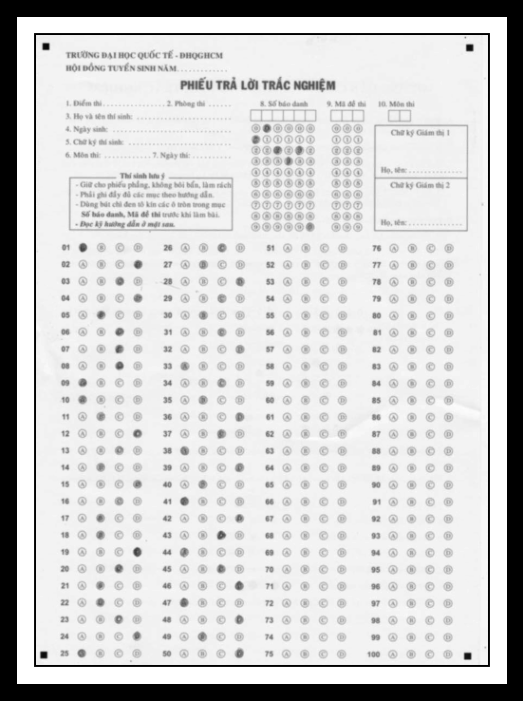

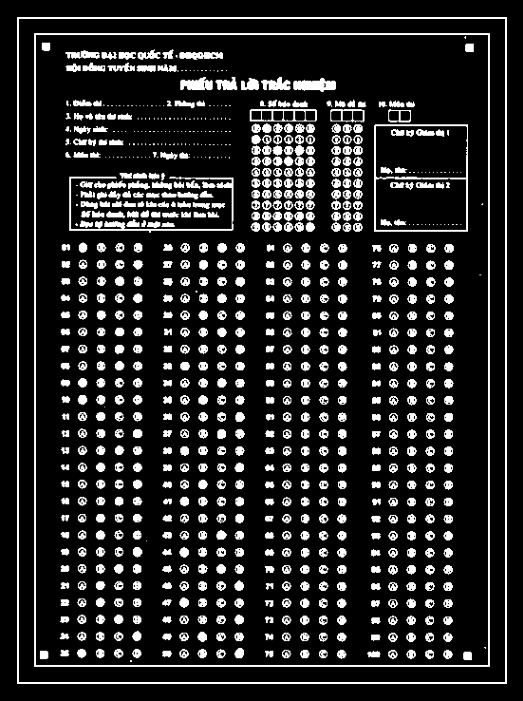

In [ ]:
# we read a result of previous lab (Lab #2) in grayscale mode
img = cv.imread('/content/result-Rotation.png',cv.IMREAD_GRAYSCALE)
# we perform some threshold to remove noise
# and retain necessary information in the answersheet
thresh = 215
maxValue = 225
# In this case, our important information is described in dark regions
# whereas, the background is indicated as white blobs.
# So we perform an INVERSE threshold to highlight our content
# if I > 215, then I = 0 [this is background]
# otherwise I = maxValue [this is our content
th, threshold_img = cv.threshold(img, thresh, maxValue, cv.THRESH_BINARY_INV);
# Display our input image
show_opencv_image_with_matplotlib(img, dpi=180)
# Display image after taking threshold
show_opencv_image_with_matplotlib(threshold_img, dpi=180)

### Define a function calculating histogram of binary w.r.t column or row

In [ ]:
"""
 Args:
 img: a binary image after we highlight significant content
 mode: mode of calculation for each row or column
 Returns:
 mhist: histogram vector which is calculated by this function
"""
def calculate_Histogram(img, mode='row'):
 # normalize image to [0,1]
 norm_img = img/np.max(img)
 mhist = None
 if mode=='row': # calculate histogram for each row
  mhist = np.zeros((img.shape[0]), dtype = "uint8")
  for i in range(img.shape[0]):
    mhist[i] = np.sum(img[i,:])

 elif mode=='column': # calculate histogram for column
  mhist = np.zeros((img.shape[1]), dtype = "uint8")
  for i in range(img.shape[1]):
    mhist[i] = np.sum(img[:,i])
 return mhist

### Visualizing function plotting histogram is necessary in this case:


In [ ]:
# Display a function visualizing histogram map calculated by the above function
"""
 Args:
 hist: histogram map which is calculated by the above function
 mode: mode of displaying for row or column histogram
"""
def draw_histogram(hist, mode='row', dpi=80, figsize=None):
  idx = np.arange(hist.shape[0])
  plt.style.use('dark_background')
  if mode=='row': # display histogram for each row
    width = [1.0]
    plt.figure(dpi=dpi, figsize=figsize)
    plt.barh(idx,np.flip(hist),height=width,color='white')
    plt.show()
  elif mode=='column': # display histogram for column
    width = [1.]
    plt.figure(dpi=dpi, figsize=figsize)
    plt.bar(idx, hist, width=width,color='white')
    plt.show()

### Calculate row histogram of the binary image, and plot corresponding result

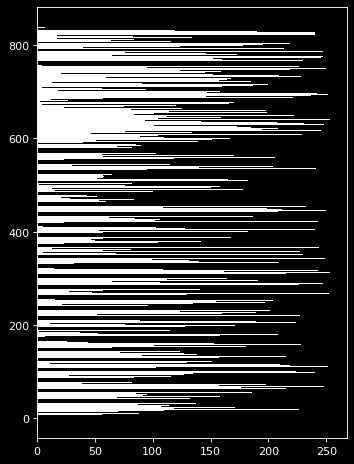

In [ ]:
# Copy threshold image above, crop left-right-top-bottom margin,
# and resize to (width=600, height=840)
image = threshold_img
margin_top = 20
margin_bottom = 10
margin_left = 20
margin_right = 40
image = image[margin_top:image.shape[0]-margin_bottom,
              margin_left:image.shape[1]-margin_right]
image = cv.resize(image, (600, 840), interpolation = cv.INTER_AREA)
# Calculate histogram for each row and display histogram map
histogram_per_row = calculate_Histogram(image, mode='row')
draw_histogram(histogram_per_row, mode='row',figsize=(5,7))

### We define a function grouping consecutive rows (a.k.a segments) having non-empty histograms:


In [ ]:
"""
 Args:
 hist: row-histogram vector which is calculated the above function with mode 'row'
 Returns:
 content_segment: a list containing elements which are groups of consecutive
rows/columns
 each segment described by (begin_idx, end_idx+1)
"""
def group_consecutive_hist_into_segments(hist):
  # Remove noise = Mark row i:
  # is_content_line[i] = 1 if hist[i]>=45
  # is_content_line[i] = 0, otherwise
  is_content_line = (hist>=10).astype(int)
  # Group lines containing content into segments
  # and save begin/end idx of each content segment
  beg = end = -1
  content_segment=list()
  for i in range(is_content_line.shape[0]):
    if is_content_line[i]==1:
      # find begin idx
      if i==0:
        beg = i
      elif is_content_line[i-1]==0:
        beg = i
      # find end idx
      if i==is_content_line.shape[0]-1:
        end = i+1
      elif is_content_line[i+1]==0:
        end = i+1
      # If find 2 beg/end points, add segment
      if (beg!=-1) and (end!=-1):
        content_segment.append((beg,end))
        beg = end = -1
  return content_segment

### Define a function group nearby segments or small segments into sections

In [ ]:
"""
 Args:
 content_segment: a list containing elements which are groups of consecutive rows
 hist: histogram vector calculated w.r.t to row/column
 threshold_distance: minimum distance between 2 sections
 threshold_segment_hist: minimum total hist of a section
 Returns:
 section: a list containing sections which are groups of consecutive rows/columns
 each section described by (begin_idx, end_idx+1)
"""
def form_sections_from_segments(content_segment, hist, threshold_distance=None, threshold_segment_hist=None):
 # Calculate the height of each content_segment
 segment_height = [content_segment[i][1] - content_segment[i][0] for i in range(len(content_segment))]
 section = list()
 current_sect = (-1,-1)
 for idx, segment in enumerate(content_segment):
  if current_sect[0]==-1 and current_sect[1]==-1:
    current_sect = (segment[0], segment[1])
    continue
  # Calculate distance from segment to current section
  distance = segment[0] - current_sect[1]
  # Calculate total content pixel of segment
  segment_hist = np.sum(hist[segment[0]:segment[1]])
  if distance<threshold_distance or segment_hist<threshold_segment_hist:
    # if segment is too small or too close to a section
    # then merge current segment to current part
    current_sect = (current_sect[0], segment[1])
  else:
    # otherwise, if segment is large enough
    # save previous section and form a new section with current segment
    section.append(current_sect)
    current_sect = (segment[0], segment[1])
  # save the last section
  if idx==len(content_segment)-1:
    section.append(current_sect)
  return section

### Perform “histogram maps → segments” on our calculated histogram map

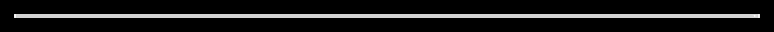

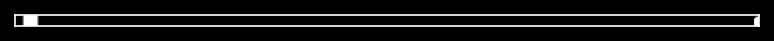

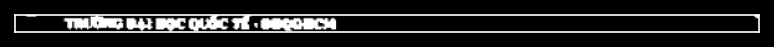

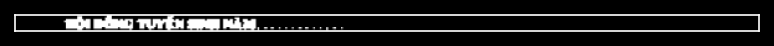

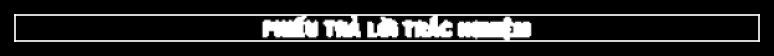

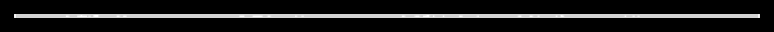

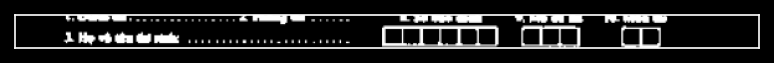

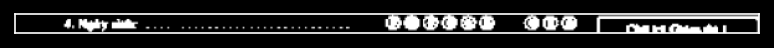

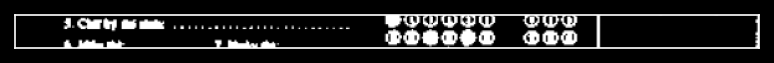

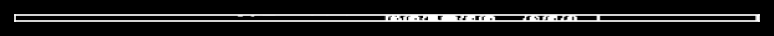

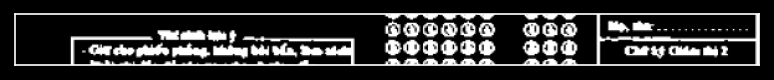

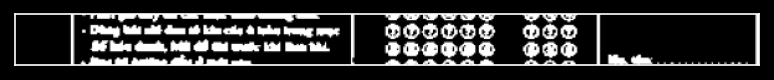

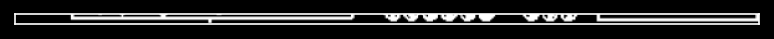

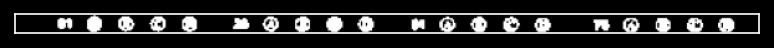

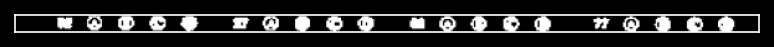

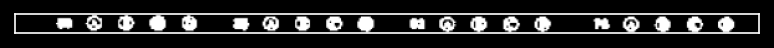

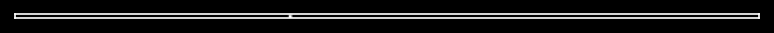

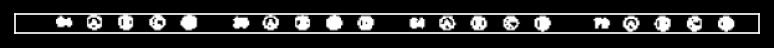

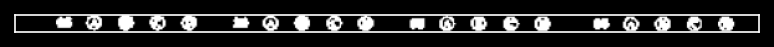

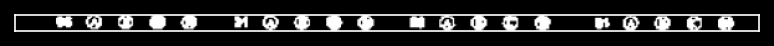

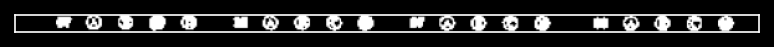

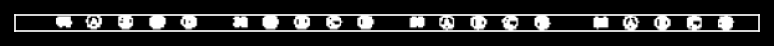

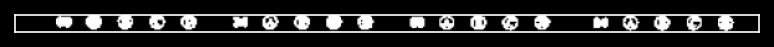

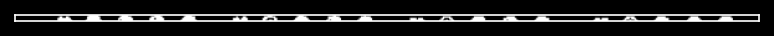

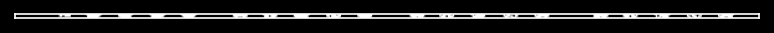

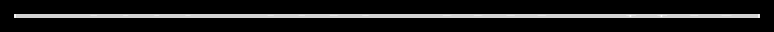

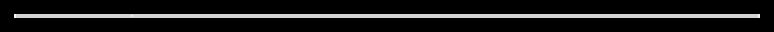

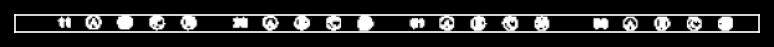

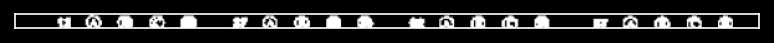

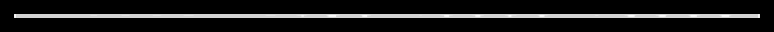

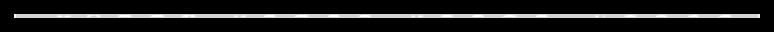

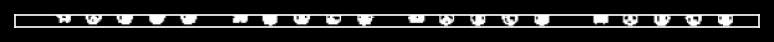

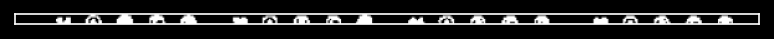

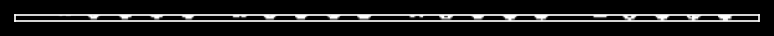

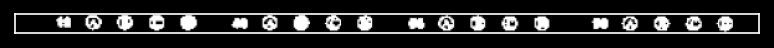

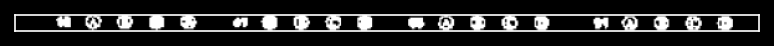

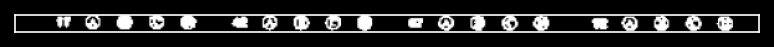

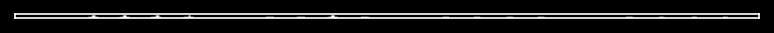

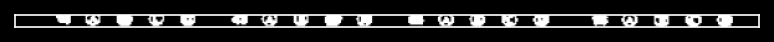

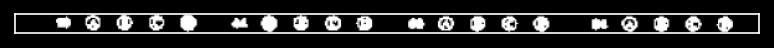

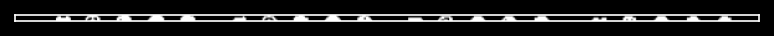

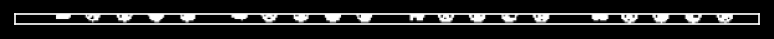

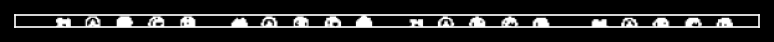

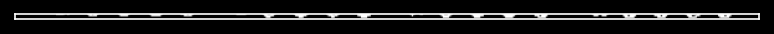

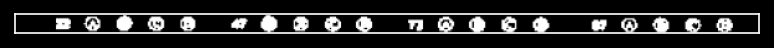

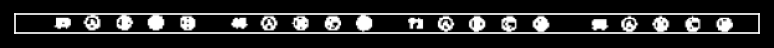

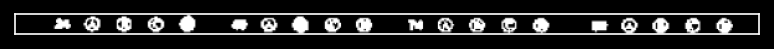

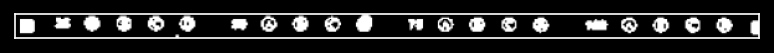

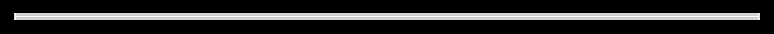

In [ ]:
# Group histogram of consecutive rows in form of segments
content_segment = group_consecutive_hist_into_segments(histogram_per_row)
# Display regions of interest (ROI) for segments
for idx, sect in enumerate(content_segment):
  # Crop a corresponding region on threshold image
  image_section = image[sect[0]:sect[1],:]
  show_opencv_image_with_matplotlib(image_section)

### We perform “segments → section” on our extracted segments

In [ ]:
# Group nearby/small segment into big sections
# [0] Exam title
# [1] Personal information and Exam code
# [2:26] Answers of 100 questions (one element for each row)
row_section_idx = form_sections_from_segments(content_segment, histogram_per_row, threshold_distance=3, threshold_segment_hist=800)
# Save regions of interest (ROI) of sections in a list and display them
row_section = list()
for idx, sect in enumerate(row_section_idx):
  # Crop a corresponding region on threshold image
  image_section = image[sect[0]:sect[1],:]
  row_section.append(image_section)
  show_opencv_image_with_matplotlib(image_section)